In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import math
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
record1 = os.listdir('Dataset/record1/radar')

In [3]:
record3 = os.listdir('record3/radar')

# Process Dataframe

In [4]:
for x in record1 :
    point = pd.read_csv(f'Dataset/record1/radar/{x}',delimiter=' ')
    point_old_cols = [float(x) for x in list(point.columns)]
    point.columns = ['X', 'Y', 'Z', 'V_R', 'M']
    point.loc[len(point),:] = point_old_cols
    point.to_csv(f'record3\{x[:-4]}.csv',index = False)

In [ ]:
for x in record3 :
    point = pd.read_csv(f'record3/radar/{x}',delimiter=' ')
    point_old_cols = [float(x) for x in list(point.columns)]
    point.columns = ['X', 'Y', 'Z', 'V_R', 'M']
    point.loc[len(point),:] = point_old_cols
    point.to_csv(f'record3\{x[:-4]}.csv',index = False)

In [ ]:
point = pd.read_csv('record1/000111.csv')

# Plot point clouds in Bird's Eye View

In [12]:
point = pd.read_csv('record1/000000.csv')
dynamic = point[point['V_R']!=0]

In [13]:
x, y = point.iloc[:,0], point.iloc[:,1]
dx, dy = dynamic.iloc[:,0], dynamic.iloc[:,1]

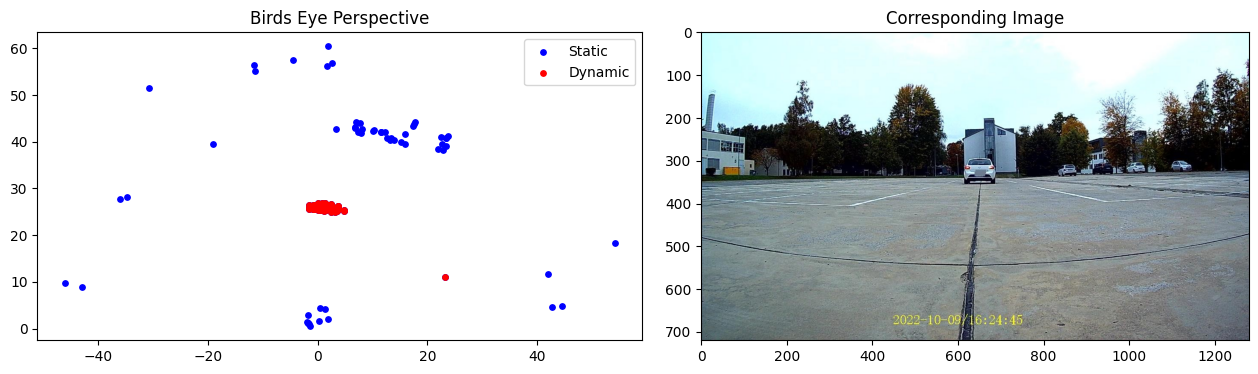

In [11]:
image = cv2.imread('Dataset/record1/camera/000000.jpg')
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(x,y, s=15, c='b', label='Static')
ax1.scatter(dx,dy, s=15, c='r', label='Dynamic')
ax1.legend()
ax1.title.set_text('Birds Eye Perspective')
ax2.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
ax2.title.set_text("Corresponding Image")
plt.subplots_adjust(wspace=0.05)
plt.show()

# Separate static and dynamic point clouds

In [7]:
points_x = []
points_y = []
points_z = []

for i in range(len(point)):
    vr = point.iloc[i,3]
    if vr != 0:
            points_x.append(point.iloc[i,0])
            points_y.append(point.iloc[i,1])
            points_z.append(point.iloc[i,2])

# Find center of the dynamic point cluster

In [8]:
cdx,cdy,cdz = np.mean(points_x),np.mean(points_y),np.mean(points_z)

# Filter points to remove noise

In [9]:
filtered_x = []
filtered_y = []
filtered_z = []
for i in range(len(points_x)):
    x = points_x[i]
    y = points_y[i]
    z = points_z[i]
    if x > cdx - 1.5 and x< cdx + 1.5 :
        if y > cdy - 2 and y < cdy + 2 :
            if z > cdz and z < cdz + 2 :
                filtered_x.append(x)
                filtered_y.append(y)
                filtered_z.append(z)
                
ex,ey,ez = np.mean(filtered_x), np.mean(filtered_y), np.mean(filtered_z)

In [10]:
def find_center_groundtruth(ground_truth):
    
    gx,gy,gz = ground_truth.iloc[2,0], ground_truth.iloc[3,0], ground_truth.iloc[4,0]
    return gx,gy,gz

# Obtain car center point from ground truth

In [11]:
centers_gt = []

In [12]:
gt_directory = os.listdir('Dataset/record1/groundtruth') 
for gt_file in gt_directory:
    ground_truth = pd.read_csv(f'Dataset/record1/groundtruth/{gt_file}')
    centers_gt.append(find_center_groundtruth(ground_truth))

# Estimate car center

In [13]:
def find_center_frame(frame):
    dx = []
    dy = []
    dz = []
    filtered_x = []
    filtered_y = []
    filtered_z = []
    dynamic_points = frame[frame['V_R']!=0]
    for i in range(len(dynamic_points)):
        dx.append(dynamic_points.iloc[i,0])
        dy.append(dynamic_points.iloc[i,1])
        dz.append(dynamic_points.iloc[i,2])

    cdx,cdy,cdz = np.mean(dx),np.mean(dy),np.mean(dz)
    
    for i in range(len(dx)):
        x = dx[i]
        y = dy[i]
        z = dz[i]
        if x > cdx - 1.5 and x< cdx + 1.5 :
            if y > cdy - 2 and y < cdy + 2 :
                if z > cdz and z < cdz + 2 :
                    filtered_x.append(x)
                    filtered_y.append(y)
                    filtered_z.append(z)
                    
    ex,ey,ez = np.mean(filtered_x), np.mean(filtered_y), np.mean(filtered_z)
    return ex,ey,ez

In [ ]:
centers_frames = []
frames = os.listdir('record1')
for frame in frames:
    point = pd.read_csv(f'record1/{frame}')
    centers_frames.append(find_center_frame(point))

In [23]:
indexes = list(range(159,168))

In [24]:
for i in indexes:
    del centers_frames[i]
    del centers_gt[i]

In [25]:
del centers_frames[-2]
del centers_gt[-2]

# Calculate distance between true and predicted car center

In [26]:
errors = []
distances = []
for i in range(len(centers_gt)):
    ex,ey,ez = centers_frames[i]
    gx,gy,gz = centers_gt[i]
    x, y, z = ex-gx, ey-gy, ez-gz
    error = np.sqrt(x**2 + y**2 + z**2)
    distance = np.sqrt(gx**2 + gy**2 + gz**2)
    errors.append(error)
    distances.append(distance)

# Find mean car width

In [27]:
widths = []
frames = os.listdir('Dataset/record1/groundtruth')
for frame in frames:
    point = pd.read_csv(f'Dataset/record1/groundtruth/{frame}')
    widths.append(float(point.columns[0]))
mean_width = round(np.mean(widths),1)
print(f'Mean car width = {mean_width} meters')

Mean car width = 2.2 meters


# Calculate algorithm accuracy

In [28]:
below_th = [x for x in errors if x < 2.2]
accuracy = len(below_th)/(len(errors)-4)  #removing 4 values in the errors which are NAN values
accuracy = round(accuracy,3)
print(f'Accuracy = {accuracy*100} %')

Accuracy = 93.10000000000001 %


# Plot errors against frame IDs

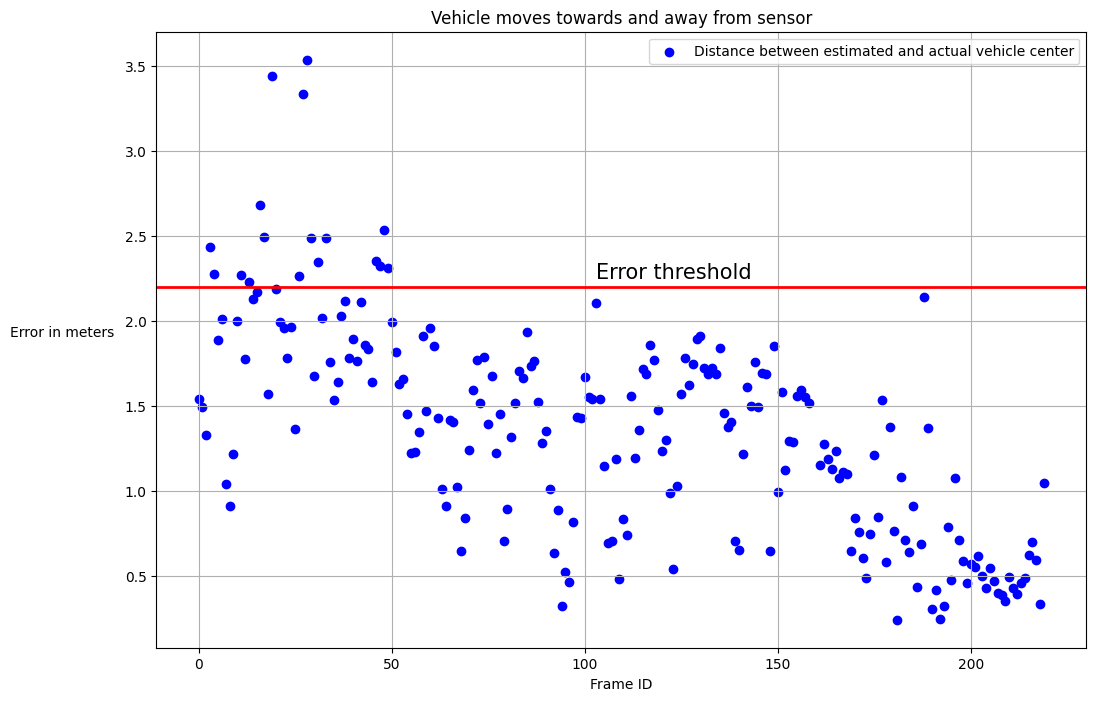

In [31]:
plt.figure(figsize=(12, 8))
plt.scatter(list(range(220)),errors,color = 'blue',label = 'Distance between estimated and actual vehicle center')
plt.title('Vehicle moves towards and away from sensor')
plt.xlabel('Frame ID')
plt.ylabel('Error in meters',rotation = 0,labelpad = 45)
plt.axhline(y=2.2, color='r', linewidth=2,linestyle='-',)
plt.text(103, 2.25, 'Error threshold', fontsize = 15)
plt.legend()
plt.grid(True)  # You can customize the grid style if needed
#plt.savefig('Errors.png')

# Show the plot
plt.show()


# Deploy algorithm on unlabelled data to estimate distance to the car

In [ ]:
centers_frames = []
frames = os.listdir('testing')
for frame in frames:
    point = pd.read_csv(f'testing/{frame}')
    centers_frames.append(find_center_frame(point))

In [33]:
distances = []
for x in centers_frames:
    x1,y1,z1 = x[0],x[1],x[2]
    distance = np.sqrt(x1**2 + y1**2 + z1**2)
    distances.append(distance)

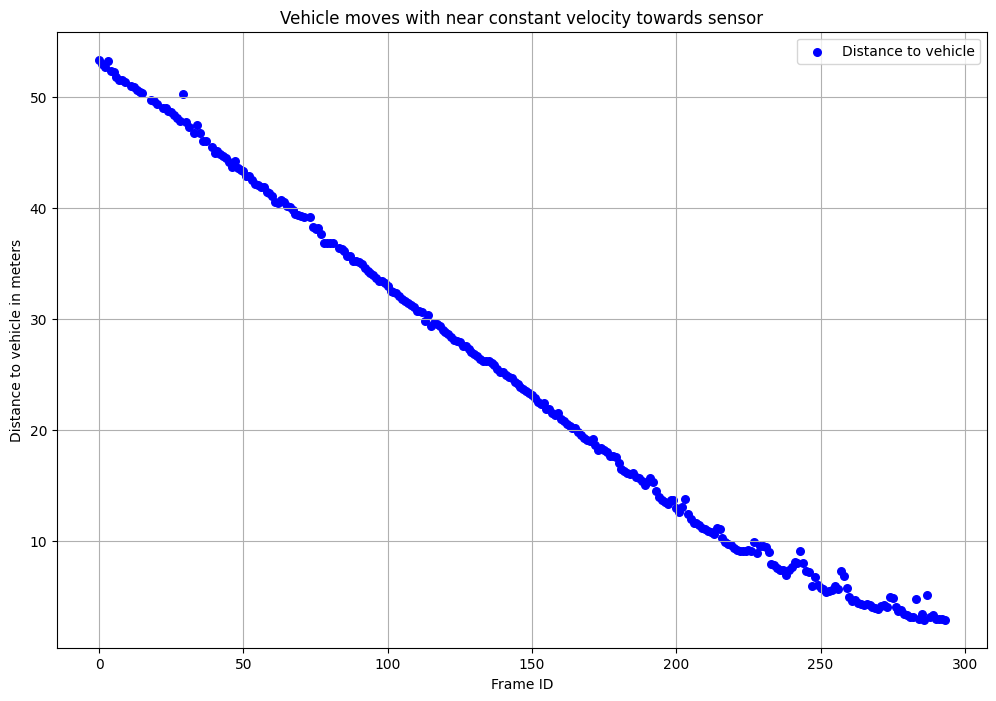

In [34]:
plt.figure(figsize=(12, 8))

plt.scatter(list(range(295)),distances,s = 30,color='blue',label = 'Distance to vehicle')
plt.title('Vehicle moves with near constant velocity towards sensor')
plt.xlabel('Frame ID')
plt.ylabel('Distance to vehicle in meters')
plt.legend()
plt.grid(True)  # You can customize the grid style if needed
plt.savefig('Test.png')
# Show the plot
plt.show()